In [1]:
print("all okay")

all okay


In [1]:
import os
import requests
from dotenv import load_dotenv
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,MessagesState,START,END
from langgraph.prebuilt import ToolNode
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
from typing import Optional,Annotated,TypedDict
from datetime import datetime
from bs4 import BeautifulSoup
from langchain_community.tools import GooglePlacesTool
from langgraph.prebuilt import tools_condition


load_dotenv()
os.environ['GROQ_API_KEY'] = os.getenv("GROQ_API_KEY")
os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")
os.environ['GPLACES_API_KEY'] = os.getenv("GPLACES_API_KEY")


In [2]:
from langchain_openai import ChatOpenAI
model_openai="gpt-4o"
llm=ChatOpenAI(model=model_openai)

In [3]:
# utilities 

def run_places_as_list(query: str):
    places = GooglePlacesTool()
    result = places.run(query)
    
    if isinstance(result, list):
        return result
    
    elif isinstance(result, str):
        lines = [line.strip() for line in result.strip().split("\n") if line.strip()]
        return lines

    return [result]

In [20]:
# define all tools

@tool
def search_attractions(city: str):
    """Searches for top attractions in a city for a trip in the specified month and duration."""
    
    query = f"find top attractions in {city}"
    print(f"Search attraction query: {query} \n")
    # call google places function to fetch the list of rstaurant
    attractions=run_places_as_list(query)
    
    return attractions

@tool
def search_restaurants(city: str):
    """Searches for recommended restaurants in a city, tailored to preferences and month."""
    
    question = f"find top restaurants in {city}"
    print(f"Search restaurant query: {question}\n")
    # call google places function to fetch the list of rstaurant
    restaurants=run_places_as_list(question)
    
    return restaurants

In [5]:
tools=[search_attractions,search_restaurants]

llm_with_tools=llm.bind_tools(tools)

In [6]:
# define pydantic class to define the structure of the data

class TripParams(BaseModel):
    city: str = Field(description="The primary city or destination (e.g., Delhi). Infer if not explicit.")
    country: Optional[str] = Field(description="Country, default to Italy if not specified.")
    duration: Optional[str] = Field(default="1 week", description="Trip length (e.g., '1 week', '3 days'). Infer reasonable default if missing.")
    month: Optional[str] = Field(description="Month or season of travel (e.g., 'July', 'June-August'). Infer from seasons.")
    start_date: Optional[str] = Field(description="Inferred start date in YYYY-MM-DD, based on current date if vague.")

In [7]:
parser = PydanticOutputParser(pydantic_object=TripParams)

In [21]:
def trip_maker(state:MessagesState):
    
    question = state["messages"][-1].content if hasattr(state["messages"][-1], 'content') else str(state["messages"][-1])
    
    system_prompt = """You are a travel assistant that uses tools to find information such as attractions and restaurants for a given location. 
Always use a tool when the user asks for something related to locations, recommendations, or travel planning. 
Only respond without tools if the query is purely conversational or opinion-based. 
Your job is to call the correct tool based on the users request, not to answer on your own.
    """
    
    human_prompt = "{query}"

    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", human_prompt)
    ])
    
    chain = prompt | llm_with_tools
    #print(f"Input Data: \n System Prompt: {system_prompt} \n Human Prompt: {human_prompt} \n Question: {question}")
    response = chain.invoke({"query": question})
    
    return {"messages": [response]}
    

In [9]:
workflow = StateGraph(MessagesState)
workflow.add_node("trip_decision", trip_maker)
workflow.add_node("tools", ToolNode(tools))
workflow.add_edge(START, "trip_decision")
workflow.add_conditional_edges(
    "trip_decision",
    tools_condition,
)
workflow.add_edge("tools", "trip_decision")
react_graph = workflow.compile()

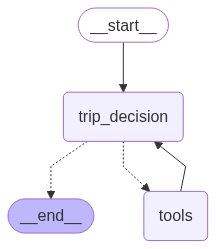

In [10]:
from IPython.display import Image, display
display(Image(react_graph.get_graph().draw_mermaid_png()))

In [14]:
message=[HumanMessage(content="Plan me a trip for 1 week to lucknow city")]

In [22]:
response =react_graph.invoke({"messages":message})

Search attraction query: Lucknow, 1 week trip top destination to vistSearch restaurant query: Lucknow, 1 week trip



In [23]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Plan me a trip for 1 week to lucknow city
================================== Ai Message ==================================
Tool Calls:
  search_attractions (call_8Fd06IKaD7jdsQnv2XzKCdPl)
 Call ID: call_8Fd06IKaD7jdsQnv2XzKCdPl
  Args:
    query: Lucknow, 1 week trip
  search_restaurants (call_gtgW7yk5mMpEWVtW9BCq1Rdk)
 Call ID: call_gtgW7yk5mMpEWVtW9BCq1Rdk
  Args:
    query: Lucknow, 1 week trip
================================= Tool Message =================================
Name: search_attractions

["1. Bara Imambara", "Address: VW86+MQ3, Husainabad Trust Rd, Machchhi Bhavan, Lucknow, Uttar Pradesh 226003, India", "Google place ID: ChIJcYt3K-79mzkRPxcoihM9LjU", "Phone: Unknown", "Website: http://lucknowimambada.in/", "2. Chota Imambada", "Address: 447, Husainabad, Lucknow, Uttar Pradesh 226003, India", "Google place ID: ChIJecYh-fv9mzkR-OIZsdOzLSQ", "Phone: 075058 39682", "Website: Unknown", "3. State

In [75]:
response=llm_with_tools.invoke("Plan me a trip for 1 week to lucknow city")

In [76]:
response.tool_calls

[{'name': 'search_attractions',
  'args': {'query': 'Lucknow attractions for a 1-week trip'},
  'id': 'call_J9yuH3Hwa6m8BBe8DdnkRZxG',
  'type': 'tool_call'},
 {'name': 'search_restaurants',
  'args': {'query': 'Lucknow restaurants for a week-long trip'},
  'id': 'call_Jof49sp0uZ3PlfTfYkW4w8QD',
  'type': 'tool_call'}]

In [24]:
print("all okay")
import os
import requests
from dotenv import load_dotenv
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,MessagesState,START,END
from langgraph.prebuilt import ToolNode
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
from typing import Optional,Annotated,TypedDict
from datetime import datetime
from bs4 import BeautifulSoup
from langchain_community.tools import GooglePlacesTool
from langgraph.prebuilt import tools_condition

load_dotenv()
os.environ['GROQ_API_KEY'] = os.getenv("GROQ_API_KEY")
os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")
os.environ['GPLACES_API_KEY'] = os.getenv("GPLACES_API_KEY")

from langchain_openai import ChatOpenAI
model_openai="gpt-4o"
llm=ChatOpenAI(model=model_openai)

# utilities 
def run_places_as_list(query: str):
    places = GooglePlacesTool()
    result = places.run(query)
    
    if isinstance(result, list):
        return result
    
    elif isinstance(result, str):
        lines = [line.strip() for line in result.strip().split("\n") if line.strip()]
        return lines

    return [result]

# define all tools with more specific queries
@tool
def search_attractions(city: str):
    """Searches for top tourist attractions, monuments, museums, and sightseeing places in a city."""
    
    query = f"top tourist attractions monuments museums sightseeing places in {city}"
    print(f"Search attraction query: {query} \n")
    # call google places function to fetch the list of attractions
    attractions=run_places_as_list(query)
    
    return attractions

@tool
def search_restaurants(city: str):
    """Searches for recommended restaurants, cafes, local food places and dining options in a city."""
    
    query = f"best restaurants cafes local food dining places in {city}"
    print(f"Search restaurant query: {query}\n")
    # call google places function to fetch the list of restaurants
    restaurants=run_places_as_list(query)
    
    return restaurants

tools=[search_attractions,search_restaurants]
llm_with_tools=llm.bind_tools(tools)

# define pydantic class to define the structure of the data
class TripParams(BaseModel):
    city: str = Field(description="The primary city or destination (e.g., Delhi). Infer if not explicit.")
    country: Optional[str] = Field(description="Country, default to Italy if not specified.")
    duration: Optional[str] = Field(default="1 week", description="Trip length (e.g., '1 week', '3 days'). Infer reasonable default if missing.")
    month: Optional[str] = Field(description="Month or season of travel (e.g., 'July', 'June-August'). Infer from seasons.")
    start_date: Optional[str] = Field(description="Inferred start date in YYYY-MM-DD, based on current date if vague.")

parser = PydanticOutputParser(pydantic_object=TripParams)

def trip_maker(state: MessagesState):
    question = state["messages"][-1].content if hasattr(state["messages"][-1], 'content') else str(state["messages"][-1])
    
    system_prompt = """You are a travel assistant that uses tools to find information such as attractions and restaurants for a given location. 
Always use BOTH tools (search_attractions AND search_restaurants) when the user asks for trip planning.
Call both tools with the city name to get comprehensive information.
Your job is to call the correct tools based on the users request, not to answer on your own.
"""
    
    human_prompt = "{query}"

    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", human_prompt)
    ])
    
    chain = prompt | llm_with_tools
    response = chain.invoke({"query": question})
    
    return {"messages": [response]}

def trip_summarizer(state: MessagesState):
    """Summarizes the trip information from tool results and provides final recommendations."""
    
    # Get the last few messages to find tool results
    messages = state["messages"]
    
    # Extract tool results
    attractions = []
    restaurants = []
    
    for msg in messages:
        if hasattr(msg, 'tool_calls') and msg.tool_calls:
            continue
        elif hasattr(msg, 'content') and isinstance(msg.content, list):
            for content_item in msg.content:
                if hasattr(content_item, 'name'):
                    if content_item.name == 'search_attractions':
                        attractions = content_item.content
                    elif content_item.name == 'search_restaurants':
                        restaurants = content_item.content
    
    # Create final summary
    summary_prompt = """Based on the attractions and restaurants found, create a comprehensive trip plan.
    
    Attractions found: {attractions}
    Restaurants found: {restaurants}
    
    Please provide:
    1. A brief overview of the destination
    2. Top 5 must-visit attractions with brief descriptions
    3. Top 5 recommended restaurants/dining options
    4. A suggested itinerary structure for the trip
    
    Keep the response concise and well-organized."""
    
    final_prompt = ChatPromptTemplate.from_template(summary_prompt)
    chain = final_prompt | llm
    
    response = chain.invoke({
        "attractions": attractions,
        "restaurants": restaurants
    })
    
    return {"messages": [response]}

# Check if tools have been called
def should_continue(state: MessagesState):
    """Determine if we should continue to tools or go to summary."""
    last_message = state["messages"][-1]
    
    # If the last message has tool calls, go to tools
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    
    # Check if we have tool results in recent messages
    recent_messages = state["messages"][-5:]  # Check last 5 messages
    has_attraction_result = False
    has_restaurant_result = False
    
    for msg in recent_messages:
        if hasattr(msg, 'content') and isinstance(msg.content, list):
            for content_item in msg.content:
                if hasattr(content_item, 'name'):
                    if content_item.name == 'search_attractions':
                        has_attraction_result = True
                    elif content_item.name == 'search_restaurants':
                        has_restaurant_result = True
    
    # If we have both results, go to summary
    if has_attraction_result and has_restaurant_result:
        return "summarize"
    
    # Otherwise continue with tools
    return "tools"

# Create the workflow
workflow = StateGraph(MessagesState)
workflow.add_node("trip_decision", trip_maker)
workflow.add_node("tools", ToolNode(tools))
workflow.add_node("summarize", trip_summarizer)

workflow.add_edge(START, "trip_decision")
workflow.add_conditional_edges(
    "trip_decision",
    should_continue,
    {
        "tools": "tools",
        "summarize": "summarize"
    }
)
workflow.add_edge("tools", "summarize")
workflow.add_edge("summarize", END)

react_graph = workflow.compile()




all okay


In [26]:
if __name__ == "__main__":
    # Test the improved workflow
    message=[HumanMessage(content="Plan me a trip for 1 week to lucknow city")]
    response = react_graph.invoke({"messages": message})

    print("=== FINAL TRIP PLAN ===")
    for m in response["messages"]:
        m.pretty_print()

Search attraction query: top tourist attractions monuments museums sightseeing places in Lucknow 
Search restaurant query: best restaurants cafes local food dining places in Lucknow


=== FINAL TRIP PLAN ===
================================ Human Message =================================

Plan me a trip for 1 week to lucknow city
================================== Ai Message ==================================
Tool Calls:
  search_attractions (call_CjR80lkVA0MQ2Eqaai8JZ1OI)
 Call ID: call_CjR80lkVA0MQ2Eqaai8JZ1OI
  Args:
    city: Lucknow
  search_restaurants (call_UrsPQ1LUxYyg9wprmgIWtGjy)
 Call ID: call_UrsPQ1LUxYyg9wprmgIWtGjy
  Args:
    city: Lucknow
================================= Tool Message =================================
Name: search_attractions

["1. Rumi Darwaza", "Address: 17/11 Hussainabad Road, Lajpat Nagar Colony, Lajpat Nagar, Machchhi Bhavan, Lucknow, Uttar Pradesh 226003, India", "Google place ID: ChIJi1guUvD9mzkR4-yW2xILN7I", "Phone: Unknown", "Website: https://r

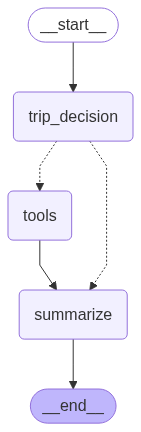

In [25]:
from IPython.display import Image, display
display(Image(react_graph.get_graph().draw_mermaid_png()))